# Cotton Disease Prediction

## Libraries

In [14]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

## Constants
Providing the image size and the train-test paths.

In [15]:
IMAGE_SIZE = [224, 224]

train_path = 'drive/MyDrive/data/train'
valid_path = 'drive/MyDrive/test'

## Model Initialisation

- Since the dataset set images are sized at (224, 224), we are selecting IMAGE_SIZE for this model.
- The dataset images are RGB, i.e. we have 3 channels, that's why we are selecting the input shape to be (224, 224, 3)
- We are using `imagenet` weights, since it has already 1000 categories, thus using pretrained weights.
- We are not including the top layer, that is the first layer, because we are providing our own top layer, i.e. IMAGE_SIZE.
- We are also removing the last layer, since that will be just our categories in which we want to classify the images (`#output_nodes = 4`).

In [16]:
resnet = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top = False)

Don't train the layers, we are going to use the existing weights from the ResNet50 model. We are doing this since we do not include the first and the last layer. We will be just training on the last layer.

In [17]:
for layer in resnet.layers:
    layer.trainable = False

In [18]:
# Getting the number of output classes
folders = glob('drive/MyDrive/data/train/*')
folders

['drive/MyDrive/data/train/diseased cotton leaf',
 'drive/MyDrive/data/train/fresh cotton leaf',
 'drive/MyDrive/data/train/diseased cotton plant',
 'drive/MyDrive/data/train/fresh cotton plant']

Flattening the model, so that we can add the number of nodes in the last layer, depending on the number of categories.

In [19]:
x = Flatten()(resnet.output)

### Adding the Output Layer

- Creating a Dense layer, with `#nodes = len(folders) = #categories`
- Choosing Activation function as `softmax`, since it would provide probabilities across number of categories. If we had just 2 categories, then we could have used `sigmoid`.

Finally, we initialise the model, with the input layers, and the output layer.

In [20]:
prediction = Dense(len(folders), activation='softmax')(x)

# Create model object
model = Model(inputs=resnet.input, outputs=prediction)

In [21]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

### Choosing the cost, optimization method and metric

In [22]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

## Data Augmentation

In [23]:
train_datagen = ImageDataGenerator(rescale = 1./255, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [24]:
training_set = train_datagen.flow_from_directory(train_path, target_size = (224, 224), batch_size = 32, class_mode = 'categorical')

Found 1951 images belonging to 4 classes.


In [25]:
test_set = test_datagen.flow_from_directory(valid_path, target_size=(224, 224), batch_size = 32, class_mode = 'categorical')

Found 18 images belonging to 4 classes.


## Fit the model

In [26]:
r = model.fit_generator(
    training_set,
    validation_data = test_set,
    epochs = 20,
    steps_per_epoch = len(training_set),
    validation_steps = len(test_set)
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/20
61/61 [==============================] - 321s 5s/step - loss: 2.9940 - accuracy: 0.3752 - val_loss: 1.1374 - val_accuracy: 0.6667
Epoch 2/20
61/61 [==============================] - 39s 632ms/step - loss: 1.0028 - accuracy: 0.6017 - val_loss: 0.8281 - val_accuracy: 0.6667
Epoch 3/20
61/61 [==============================] - 38s 629ms/step - loss: 0.9617 - accuracy: 0.6115 - val_loss: 0.7825 - val_accuracy: 0.6111
Epoch 4/20
61/61 [==============================] - 40s 651ms/step - loss: 0.8960 - accuracy: 0.6463 - val_loss: 0.8695 - val_accuracy: 0.7778
Epoch 5/20
61/61 [==============================] - 38s 628ms/step - loss: 0.8977 - accuracy: 0.6520 - val_loss: 0.6402 - val_accuracy: 0.7778
Epoch 6/20
61/61 [==============================] - 39s 631ms/step - loss: 0.7248 - accuracy: 0.7048 - val_loss: 0.8351 - val_accuracy: 0.6111
Epoch 7/20
61/61 [==============================] - 39s 632ms/step - loss: 0.7396 - accuracy: 0.6971 - val_loss: 1.2651 - val_accuracy: 0.6111
E

## Visualizations

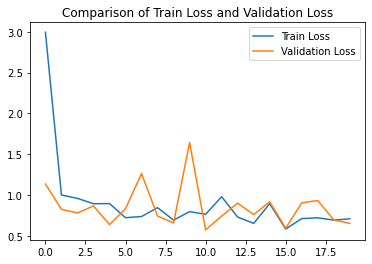

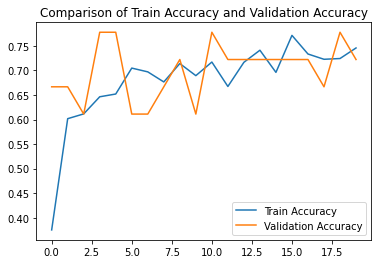

In [32]:
# Plot the Loss
plt.plot(r.history['loss'], label='Train Loss')
plt.plot(r.history['val_loss'], label='Validation Loss')
plt.title('Comparison of Train Loss and Validation Loss')
plt.legend()
plt.savefig('loss_and_val_loss')
plt.show()

# Plot the Accuracy
plt.plot(r.history['accuracy'], label='Train Accuracy')
plt.plot(r.history['val_accuracy'], label='Validation Accuracy')
plt.title('Comparison of Train Accuracy and Validation Accuracy')
plt.legend()
plt.savefig('accuracy_and_val_accuracy')
plt.show()

## Save the model

In [33]:
model.save('cotton_disease_resent50.h5')

## Predictions

In [28]:
y_pred = model.predict(test_set)
y_pred # Shows the probabilities of each category for each image from the test dataset

array([[4.57120506e-04, 6.66449182e-07, 7.24934274e-04, 9.98817265e-01],
       [5.75565081e-03, 1.89429906e-03, 9.30862904e-01, 6.14870414e-02],
       [1.50136545e-03, 4.41622367e-04, 9.96003687e-01, 2.05341447e-03],
       [5.83680638e-04, 2.27826517e-02, 1.55986464e-02, 9.61035073e-01],
       [2.05515316e-04, 3.26401703e-02, 8.84559751e-03, 9.58308816e-01],
       [2.82368215e-04, 6.57791986e-07, 9.99706089e-01, 1.08768045e-05],
       [1.37286086e-04, 1.39366020e-04, 9.94759500e-01, 4.96378960e-03],
       [6.45257300e-04, 1.26632466e-03, 6.05597161e-03, 9.92032528e-01],
       [2.92056173e-01, 2.53033787e-01, 1.41811958e-02, 4.40728843e-01],
       [8.34340390e-05, 1.29871825e-02, 1.63215480e-03, 9.85297263e-01],
       [5.71915768e-02, 1.88934147e-01, 1.09638916e-02, 7.42910385e-01],
       [2.86984374e-03, 9.00522232e-01, 1.86678852e-04, 9.64212194e-02],
       [1.43791270e-02, 3.89639825e-01, 3.16157907e-01, 2.79823124e-01],
       [9.97559071e-01, 7.05600840e-08, 6.21570449e

In [29]:
# Selecting the category based on maximum probability
y_pred = np.argmax(y_pred, axis = 1)
y_pred

array([3, 2, 2, 3, 3, 2, 2, 3, 3, 3, 3, 1, 1, 0, 1, 1, 2, 3])

# Getting the Requirements list

In [34]:
!pip freeze > requirements.txt